   movieId                               title  \
0        1                    Toy Story (1995)   
1        2                      Jumanji (1995)   
2        3             Grumpier Old Men (1995)   
3        4            Waiting to Exhale (1995)   
4        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Comedy|Romance  
3                         Comedy|Drama|Romance  
4                                       Comedy  
   userId  movieId  rating  timestamp
0       1        1     4.0  964982703
1       1        3     4.0  964981247
2       1        6     4.0  964982224
3       1       47     5.0  964983815
4       1       50     5.0  964982931


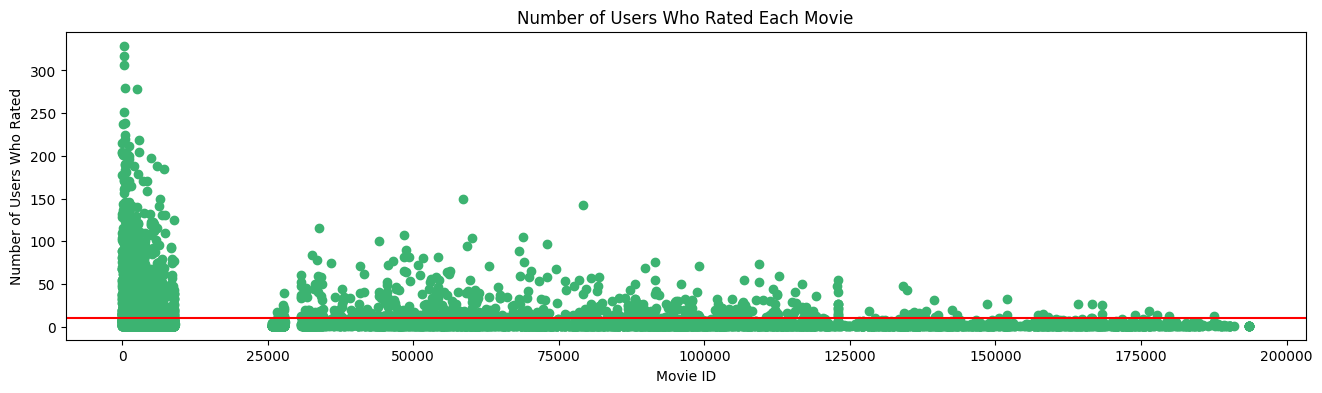

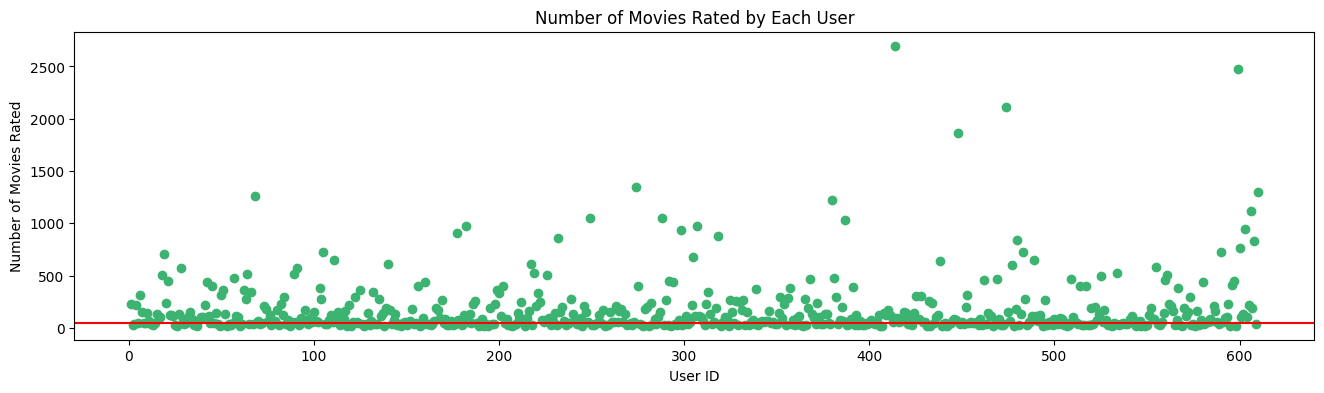

Sparsity of the sample data: 0.7333333333333334
CSR matrix of the sample data:
   (0, 2)	3
  (1, 0)	4
  (1, 4)	2
  (2, 4)	1
                             Title  Distance
1                        Up (2009)  0.368857
2   Guardians of the Galaxy (2014)  0.368758
3                  Watchmen (2009)  0.368558
4                 Star Trek (2009)  0.366029
5             Batman Begins (2005)  0.362759
6                    Avatar (2009)  0.310893
7                Iron Man 2 (2010)  0.307492
8                    WALL·E (2008)  0.298138
9          Dark Knight, The (2008)  0.285835
10            Avengers, The (2012)  0.285319


In [5]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
from scipy.sparse import csr_matrix
from sklearn.neighbors import NearestNeighbors

# Load the datasets
movies = pd.read_csv("movies.csv")
ratings = pd.read_csv("ratings.csv")

# Display initial rows of the movies dataset
print(movies.head())

# Display initial rows of the ratings dataset
print(ratings.head())

# Create a user-item matrix with movies as rows and users as columns
user_item_matrix = ratings.pivot(index='movieId', columns='userId', values='rating')
user_item_matrix.fillna(0, inplace=True)

# Count the number of users who rated each movie
users_per_movie = ratings.groupby('movieId')['rating'].count()

# Count the number of movies rated by each user
movies_per_user = ratings.groupby('userId')['rating'].count()

# Plot the number of users who rated each movie
plt.figure(figsize=(16, 4))
plt.scatter(users_per_movie.index, users_per_movie, color='mediumseagreen')
plt.axhline(y=10, color='r')
plt.xlabel('Movie ID')
plt.ylabel('Number of Users Who Rated')
plt.title('Number of Users Who Rated Each Movie')
plt.show()

# Filter out movies with fewer than 10 ratings
user_item_matrix = user_item_matrix.loc[users_per_movie[users_per_movie > 10].index, :]

# Plot the number of movies rated by each user
plt.figure(figsize=(16, 4))
plt.scatter(movies_per_user.index, movies_per_user, color='mediumseagreen')
plt.axhline(y=50, color='r')
plt.xlabel('User ID')
plt.ylabel('Number of Movies Rated')
plt.title('Number of Movies Rated by Each User')
plt.show()

# Filter out users who rated fewer than 50 movies
user_item_matrix = user_item_matrix.loc[:, movies_per_user[movies_per_user > 50].index]

# Sample data to demonstrate sparsity
sample_data = np.array([[0, 0, 3, 0, 0], [4, 0, 0, 0, 2], [0, 0, 0, 0, 1]])
sample_sparsity = 1.0 - (np.count_nonzero(sample_data) / float(sample_data.size))
print("Sparsity of the sample data:", sample_sparsity)

# Convert the sample data to a CSR (Compressed Sparse Row) matrix
sample_csr = csr_matrix(sample_data)
print("CSR matrix of the sample data:\n", sample_csr)

# Convert the user-item matrix to a CSR matrix
csr_user_item_matrix = csr_matrix(user_item_matrix.values)
user_item_matrix.reset_index(inplace=True)

# Train a k-Nearest Neighbors model
knn_model = NearestNeighbors(metric='cosine', algorithm='brute', n_neighbors=20, n_jobs=-1)
knn_model.fit(csr_user_item_matrix)

# Function to recommend movies based on a given movie title
def recommend_movies(movie_title):
    recommendations_count = 10
    movie_matches = movies[movies['title'].str.contains(movie_title, case=False)]
    if len(movie_matches):
        movie_id = movie_matches.iloc[0]['movieId']
        movie_index = user_item_matrix[user_item_matrix['movieId'] == movie_id].index[0]
        distances, indices = knn_model.kneighbors(csr_user_item_matrix[movie_index], n_neighbors=recommendations_count + 1)
        recommended_movies = sorted(list(zip(indices.squeeze().tolist(), distances.squeeze().tolist())), key=lambda x: x[1])[:0:-1]
        recommendation_frame = []
        for val in recommended_movies:
            recommended_movie_id = user_item_matrix.iloc[val[0]]['movieId']
            idx = movies[movies['movieId'] == recommended_movie_id].index
            recommendation_frame.append({'Title': movies.iloc[idx]['title'].values[0], 'Distance': val[1]})
        recommendations_df = pd.DataFrame(recommendation_frame, index=range(1, recommendations_count + 1))
        return recommendations_df
    else:
        return "No movies found. Please check your input."

# Example usage
movie_recommendations = recommend_movies('Iron Man')
print(movie_recommendations)
